# Project 3
**Group 2** 
Ada Matilde Gige (adgi@itu.dk), Albert Schiffer (albsc@itu.dk), Andreas Frederik Flensted Olsen (frao@itu.dk), Timothy Beck (tibe@itu.dk) and Victor Popp Henriksen (vhen@itu.dk)

Created: 2021-04-06

Last modified: 2021-04-22

Link to repo: https://github.com/adagige/fyp2021p03g02.git

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns

from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage import transform
from PIL import Image 

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import confusion_matrix


import glob #For finding specific file types

%run -i ../fyp2021p3_group00_functions.py

# Running or watching code?

### If you are interested in only watching the code set the constant run to False, if you want to run the code set the constant to True

When watching the code some files will be loaded, but it is feature files which are already made by the code in the Notebook and then saved

In [2]:
run = False

# Loading raw datafiles

In [3]:

#load all images of type .jpg
im_file_list2 = glob.glob("../data/example_image/*.jpg")
#load all maps of type .png
map_file_list2 = glob.glob("../data/example_segmentation/*.png")

#load external images 
im_file_liste = glob.glob("../data/external_data/resized_images/*.jpg")
#Load external maps
map_file_liste = glob.glob("../data/external_data/resized_masks/*.png")

#im_files = sorted(im_file_list2, key = uniq)
im_files = sorted(im_file_list2)
len(im_files)

#map_files = sorted(map_file_list2, key = uniq)
map_files = sorted(map_file_list2)
len(map_files)

#im_files = sorted(im_file_list2, key = uniq)
im_filese = sorted(im_file_liste)
len(im_filese)

#map_files = sorted(map_file_list2, key = uniq)
map_filese = sorted(map_file_liste)
len(map_filese)    



# Loading the true file in
true1 = pd.read_csv('../data/example_ground_truth.csv')
true2 = pd.read_csv('../data/external_data/resized_ISIC-2017_Training_Part3_GroundTruth.csv')

true = pd.concat([true1, true2], ignore_index=True)
# It is already sorted why it is not sorted as the others


## Loading the images into a list and making an ID dictionary
Taken from: https://stackoverflow.com/questions/33369832/read-multiple-images-on-a-folder-in-opencv-python/33371454

In [ ]:
images = []
for file in im_files:
    im = Image.open(file)
    im = im.resize((800,500), resample=1) 
    images.append(im)

for file in im_filese:
    im = Image.open(file)
    images.append(im)

maps = []

for file in map_files:
    ma = Image.open(file)
    ma = ma.resize((800,500), resample=1)
    maps.append(ma)

for file in map_filese:
    ma = Image.open(file)
    maps.append(ma)


# Making a dictionary to find the id from the index
pic_id = dict()

for i in range(150):
    pic_id[i] = true['image_id'][i]

# Features
We used the ABC features to classify the features of melanoma and not melanoma marks.

## Asymetry
The asymetry is meassured by finding the center of the image, measuring the distance to the border on each side and comparing the two, the difference was squared to prevent negative number and added to the onstant difference. Then the image was rotated 5 degrees and the mesurement was done once again, the image was rotated 36 times. Adter the rotation the difference was divided by the area of the lesion to normalise the meassurement. 

In [ ]:
#A function that finds the center of a picture and meassures the asymmetri

def asymmetry(mapID):
    mask = np.array(maps[mapID])
    
    borders = np.where(mask == 1) # This will return 2 arrays with the index where the pixels are ones
    up, down, left, right = max(borders[0]), min(borders[0]), min(borders[1]), max(borders[1])
    center = ((left + right)//2, (up+down) //2) # Tuple with the coordinates for the center of the lesion
    
    difference = 0
    
    for i in range(36):
        borders = np.where(mask == 1) # This will return 2 arrays with the index where the pixels are ones
        left, right = min(borders[1]), max(borders[1])
        
        radiusdiff = (center[0]-left) - (right-center[0])
        difference += radiusdiff**2
        mask = transform.rotate(mask, 5, center = center)
    return difference/area[mapID]
    

We ran all images through the function via the lines of code below and saved the output to a file to save time.

In [ ]:
# Making a list with all asymmetry values in it and then savin it.
if run:
    asymmetrylist = []

    for i in range(300):
        asymmetrylist.append(asymmetry(i))

    np.savetxt("../data/features/asymmetry36.csv", asymmetrylist, delimiter=",")

### Showing how the asymetry function works (simplified)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))

mask = np.array(maps[4])

borders = np.where(mask == 1) # This will return 2 arrays with the index where the pixels are ones
up, down, left, right = max(borders[0]), min(borders[0]), min(borders[1]), max(borders[1])
center = ((left + right)//2, (up+down) //2) # Tuple with the coordinates for the center of the lesion

difference = 0

for i in range(4):
    borders = np.where(mask == 1) # This will return 2 arrays with the index where the pixels are ones
    left, right = min(borders[1]), max(borders[1])
   
    
    axes[i].imshow(mask, cmap = 'gray')
    axes[i].scatter(center[0], center[1], s=25, c='red', marker='o')
   # axes[i].show()
    
    radiusdiff = (center[0]-left) - (right-center[0])
    difference += radiusdiff**2
    mask = transform.rotate(mask, 45, center = center)

fig.tight_layout()

## Border

To measure the regularity of the border the ration perimeter divided by area was used. The area and perimeter ratio has shown great results in other studies, Fikrle and Pizinger 2007. 
https://groups.inf.ed.ac.uk/vision/MCDONAGH/related%20work/literature/digital%20computer%20analysis%20of%20dermatoscopical%20images%20-%20Fikrle%20Pizinger%20-%20March%202006.pdf

### Area and perimeter
To find the area and perimeter we used the function from Veronicka with the morphology.disk() set to 5.
We tried different values of morphology.disk() but 5 was found to the the best meassurement for the feature.

In [ ]:
if run: 
    #Loading the maps in as plt files to be used to find the area an perimiter.

    #load all maps of type .png
    map_file_area = glob.glob("../data/example_segmentation_resize/*.png")

    #Load external maps
    map_filee_area = glob.glob("../data/external_data/resized_masks/*.png")


    map_files_area = sorted(map_file_area)

    map_filese_area = sorted(map_filee_area)   


    mapsarea = []

    for file in map_files_area:
        im = plt.imread(file)
        mapsarea.append(im)

    for file in map_filese_area:
        im = plt.imread(file)
        mapsarea.append(im)


In [ ]:
if run: 
    # Finding the area and perimeter of all images. 
    '''With the use of morphology.disk(5)'''


    areas = []
    peris = []
    for i in mapsarea:
        area, perimiter = measure_area_perimeter(i)
        areas.append(area)
        peris.append(perimiter)

    # Adding them to a file, so they don't have to be calculated each time

    #np.savetxt("../data/features/perimeter5.csv", peris, delimiter=",")
    #np.savetxt("../data/features/area5.csv", areas, delimiter=",")

#### Area and perimeter scatterplot

In [ ]:
if not run: 
    area = np.genfromtxt('../data/features/area5.csv', delimiter=',')
    perimeter = np.genfromtxt('../data/features/perimeter5.csv', delimiter=',')

In [ ]:
def scatterplot(area, perimeter):
    # Define the size of the figure
    fig = plt.figure(figsize=(4, 3))
    # Set axes, that you want to work with:
    axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)
    # actually plot the data:
    axes.scatter(area, perimeter, label = 'Data', edgecolors='white')
    axes.set_title('Area and perimeter')
    axes.set_xlabel('Area')
    axes.set_ylabel('Perimeter')
    #axes.legend(loc='upper left'); axes.set_xlabel(data); axes.set_ylabel(data); axes.set_title('Scatter plot');
    return None

In [ ]:
scatterplot(area, perimeter)

### Perimeter divided by area

In [ ]:
if run:
    #making the perimiter divided by area feature
    pa = []
    for i in range(300): 
        pa.append(perimeter5[i]/areas5[i])

    # Making a file with the perimeter divided by area feature
    #np.savetxt("../data/features/perimeterdivarea5.csv", pa, delimiter=",")

In [ ]:
if not run: 
    pa = np.genfromtxt('../data/features/perimeterdivarea5.csv', delimiter = ',')

#### Histogram with the perimeter/area

In [ ]:
sns.histplot(pa, bins = 20)

## Color segmentation

In [ ]:
def color_segmentation(list_of_images, list_of_corresponding_masks): #lists with resized and resampled images
    '''this function takes the 2 lists as input, the one list with images, and the other with its corresponding masks (both resized)
    For each masked image, it performs a felzensvalb algorithim, to compute the segmentation of the mole. The segmentation is 
    normalized (divided by the totalt number of pixels in the mole), and afterwards put into the dataframe as a feature.
    '''
    segmentation = []
    
    for i in range(len(list_of_images)): #the file list
        img1 = list_of_images[i]

        img2 = list_of_corresponding_masks[i]

        img2.paste(img1, (0,0), mask = img2) 

        segments_fz = felzenszwalb(img2, scale=8, sigma=1, min_size=10)

        number_of_segments = len(np.unique(segments_fz))

        normalized_segmentation = round(number_of_segments/(np.sum(list_of_corresponding_masks[i])),7)

        segmentation.append(normalized_segmentation)
    
    return segmentation

In [ ]:
if run: 
    #call the function
    felz = color_segmentation(images, maps) 

    ''' Exported as a csv file to avoid future run time
    '''

    #np.savetxt("../data/features/segmentation.csv", felz, delimiter=",")

In [ ]:
'''To see what is going on inside the loop, is a cutout for only 1 picture in this block of code
'''
if not run: 
    img1 = images[0].copy()
    img2 = maps[0].copy()
    img2.paste(img1, (0,0), mask = img2) 
    segments_fz = felzenszwalb(img2, scale=8, sigma=1, min_size=10)
    number_of_segments = len(np.unique(segments_fz))
    normalized_segmentation = round(number_of_segments/(np.sum(maps[0])),7)
    plt.imshow(mark_boundaries(img2, segments_fz))
    print('pixels in mask divided by area of mask = ', normalized_segmentation)
    #segmenation[images[i]] = normalized_segmentation

# Testing features
All test images were drawn by hand in Paint in black and white. Afterwards they were converted to Luminance pictures. The features were tested on the converted pictures, to see how the features behaved.

In [ ]:
def asym(mask, area):
    '''Function to find the asymmetry of test features, the only difference from the original asymmetry is that the area is a 
    parameter'''

    borders = np.where(mask == 1) # This will return 2 arrays with the index where the pixels are ones
    up, down, left, right = max(borders[0]), min(borders[0]), min(borders[1]), max(borders[1])
    center = ((left + right)//2, (up+down) //2) # Tuple with the coordinates for the center of the lesion
    
    difference = 0
    
    for i in range(36):
        borders = np.where(mask == 1) # This will return 2 arrays with the index where the pixels are ones
        left, right = min(borders[1]), max(borders[1])
        
        
        radiusdiff = (center[0]-left) - (right-center[0])
        difference += radiusdiff**2
        mask = transform.rotate(mask, 5, center = center)
        
    return difference/area

In [ ]:
if not run: 
    circle = plt.imread('../data/test_pictures/circleL.png')
    irregular = plt.imread('../data/test_pictures/irregularL.png')
    irregular2 = plt.imread('../data/test_pictures/irregular2L.png')
    irregular3 = plt.imread('../data/test_pictures/irregular3L.png')


    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

    axes[0][0].imshow(circle, cmap = 'gray')
    axes[0][0].set_title(label = 'Circle')
    axes[0][1].imshow(irregular, cmap = 'gray')
    axes[0][1].set_title('Irregular 1')
    axes[1][0].imshow(irregular2, cmap = 'gray')
    axes[1][0].set_title('Irregular 2')
    axes[1][1].imshow(irregular3, cmap = 'gray')
    axes[1][1].set_title('Irregular 3')


    area1, perimeter1 = measure_area_perimeter(circle)
    area2, perimeter2 = measure_area_perimeter(irregular)
    area3, perimeter3 = measure_area_perimeter(irregular2)
    area4, perimeter4 = measure_area_perimeter(irregular3)


    print('The perimeter/area is:','circle', round(perimeter1/area1, 3), 'irregular', round(perimeter2/area2, 3), 'irregular2', 
          round(perimeter3/area3,3), 'irregular3', round(perimeter4/area4, 3))



    asym1 = asym(circle, area1)
    asym2 = asym(irregular, area2)
    asym3 = asym(irregular2, area3)
    asym4 = asym(irregular3, area4)

    print('The asymetry is:','circle', round(asym1, 3), 'irregular', round(asym2,3), 'irregular2', round(asym3,3),
          'irregular3', round(asym4,3))

# All features in one dataframe with true values
All the features are gathered in one dataframe, because of time each feature are loaded from their respective file.

In [4]:
areas = pd.read_csv("../data/features/area5.csv", names = ['area'])
perimeter = pd.read_csv("../data/features/perimeter5.csv", names = ['perimeter'])
pa = pd.read_csv('../data/features/perimeterdivarea5.csv', names = ['peri/area'])
asymmetry = pd.read_csv("../data/features/asymmetry36.csv", names = ['asymmetry'])
segmentation = pd.read_csv("../data/features/segmentation.csv", names = ['color segmentation/area'])

true['asymmetry'] = asymmetry
true['area'] = areas
true['perimeter'] = perimeter
true['peri/area'] = pa
true['color segmentation/area'] = segmentation

allfeatures = true

C:\Users\adagi\anaconda3\lib\site-packages\seaborn\axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


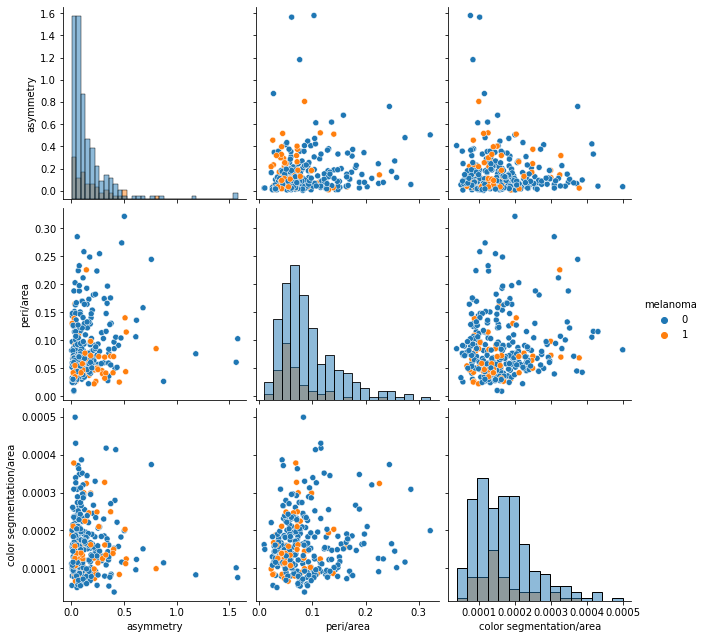

In [6]:
toplot = allfeatures[['asymmetry', 'peri/area','color segmentation/area' ,'melanoma']]

sns.pairplot(toplot, hue="melanoma", size=3,diag_kind="hist")

## Scaling the data
We decided to scale the data by using the StadardScaler() from sklearn but only on a datafram containing the features

In [6]:
onlyfeatures = allfeatures[[ 'asymmetry', 'peri/area', 'color segmentation/area']]

-7.894919286223335e-18
1.0


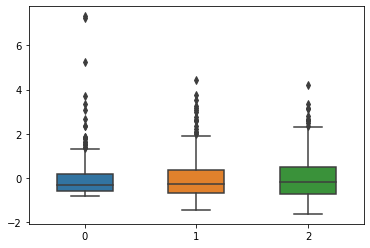

In [7]:
# Scaling the features

#Fit scaler on our data
scaler = preprocessing.StandardScaler().fit(onlyfeatures)

#Apply to data itself
normfeatures = scaler.transform(onlyfeatures)

print(normfeatures.mean()) #small number close to 0, round of error
print(normfeatures.var())  #equal to 1 
sns.boxplot(data=normfeatures, width=0.5,fliersize=5) #we see both negative and positive values, since the mean is 0

## Plotting the features
The features are plotted with the melanoma/ not melanoma hue. 

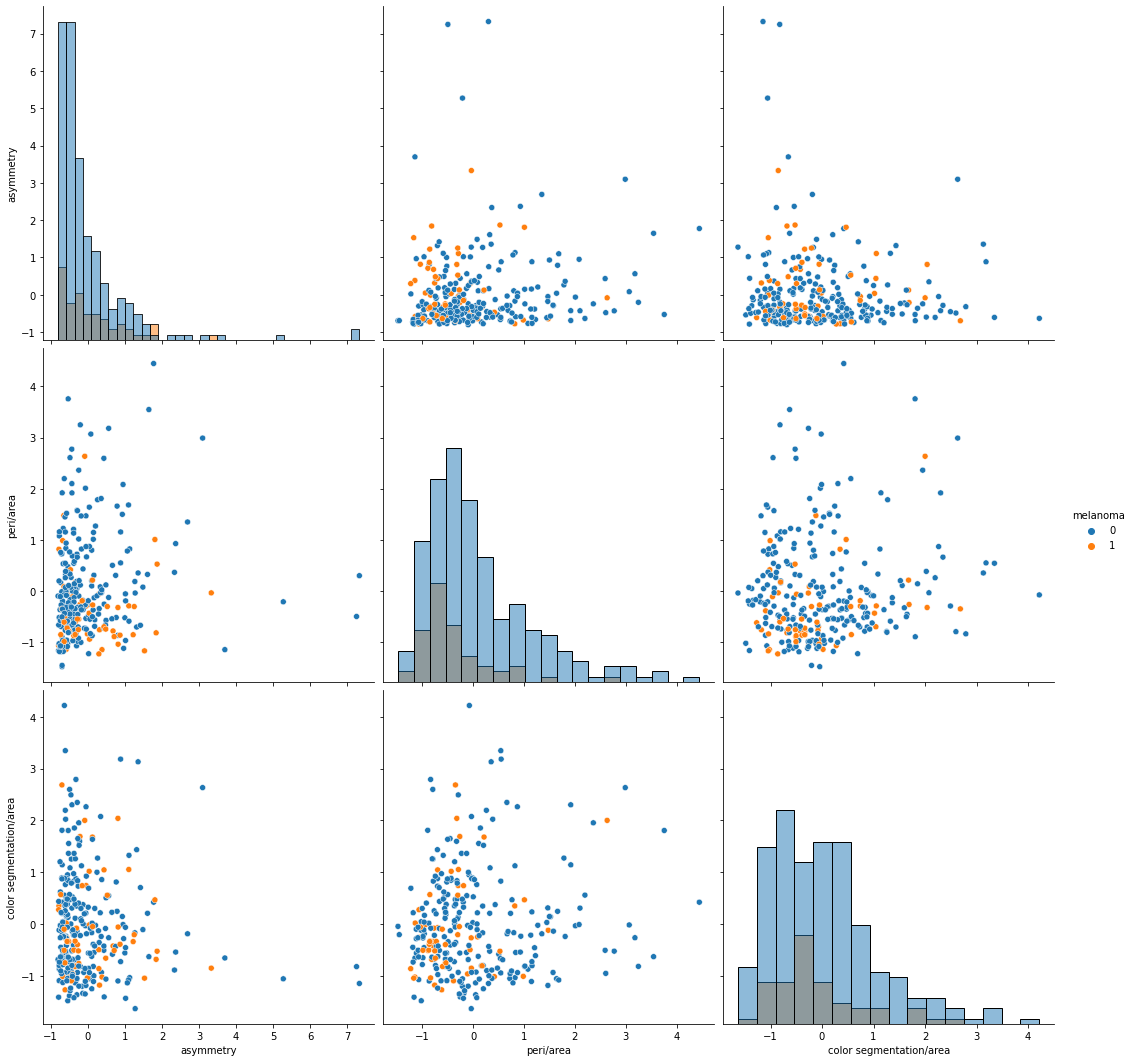

In [8]:
normfeatures = pd.DataFrame(normfeatures, columns = [ 'asymmetry', 'peri/area', 'color segmentation/area'])

# Look at values per class
normfeatures['melanoma'] = allfeatures['melanoma']


p = sns.pairplot(normfeatures, hue="melanoma", height=5,diag_kind="hist", vars = ['asymmetry', 'peri/area', 'color segmentation/area'])

p.savefig("output.png")

# Ordinary classification with k- nearest neighbor, Support vector mahine and decision tree classifier

### Splitting the data

In [ ]:
# Some noisy data not correlated
noise = np.random.RandomState(42).uniform(0, 0.1, size=(normfeatures.shape[0], 20))

# Add the noisy data to the informative features
X = np.hstack((normfeatures[['asymmetry', 'peri/area',  'color segmentation/area' ]], noise))
y = normfeatures['melanoma']

# Split dataset to select feature and evaluate the classifier 
# Splitting the data in training 70 % (240/300) validation 10% (30) and test 20% (60) 
X_dev, X_test, y_dev, y_test = train_test_split(
        X, y, stratify=y, random_state=0, test_size = 0.2)

X_train, X_val, y_train, y_val = train_test_split(
        X_dev, y_dev, stratify=y_dev, test_size = 0.125, random_state = 0)

In [ ]:
# Univariate feature selection with mutual information for feature scoring --> #mutual_info_classif
selector = SelectKBest(mutual_info_classif, k=2) #returns an array of scores and of pvalues.
selector.fit(X_train, y_train)

scores = selector.scores_ #call the array of scores

# Select features that had good scores on training set
X_train1 = X_train[:, [0,3]]
X_train2 = selector.transform(X_train)

### Model training

In [ ]:
# Train a classifier
#KNearest Neighbours
knn1 = KNeighborsClassifier(n_neighbors=10) # other hyperparameters possible, 10 as nearest neighbors seems like the optimal number
knn1trained = knn1.fit(X_train2, y_train)
#KNearest Neighbours other parameter
knn2 = KNeighborsClassifier(n_neighbors=2)
knn2trained = knn2.fit(X_train2, y_train)
#Decisiontree
tree1 = DecisionTreeClassifier(max_depth=2) # various hyperparameters, max depth = 2 from 1. semester
tree1trained = tree1.fit(X_train2, y_train)
#Support vector machine
svm1 = svm.SVC(gamma='scale')
svmtrained = svm1.fit(X_train2, y_train)

In [ ]:
#Select the same features as before
X_val1 = X_val[:, [0,3]]
X_val2 = selector.transform(X_val) # .transform --> reduces the array of all scores to only the best scores

y_val_knn1 = knn1trained.predict(X_val2)
y_val_knn2 = knn2trained.predict(X_val2) 
y_val_svm1 = svmtrained.predict(X_val2)
y_val_tree = tree1trained.predict(X_val2)

# Simple accuracy
print((np.sum(y_val_knn1 == y_val) / np.size(y_val) * 100), 'KNN with k=10')
print((np.sum(y_val_knn2 == y_val) / np.size(y_val) * 100), 'KNN with k=2')
print((np.sum(y_val_tree == y_val) / np.size(y_val) * 100), 'Decisiontree with max depth of 2')
print((np.sum(y_val_svm1 == y_val) / np.size(y_val) * 100), 'Support vector machine, with rbf kernel and gamma set to (1/#features*Variance)')


In [ ]:
from sklearn.metrics import roc_auc_score

auc1 = roc_auc_score(y_val, y_val_knn1)
auc2 = roc_auc_score(y_val, y_val_knn2)
auc3 = roc_auc_score(y_val, y_val_svm1)
auc4 =roc_auc_score(y_val, y_val_tree)

print(auc1, 'KNN with k=10')
print(auc2,'KNN with k=2')
print(auc3,'Decisiontree with max depth of 2')
print(auc4, 'Support vector machine, with rbf kernel and gamma set to (1/#features*Variance)')


The classifiers are not that great, why we look at crodd validation instead, because of the rather small dataset.

# Cross validation with k- nearest neighbor, Support vector mahine and decision tree classifier

### Splitting the data

In [ ]:
## Splitting the data in training 80 % (225/300) and test 25% (75)

Xc = normfeatures[['asymmetry', 'peri/area',  'color segmentation/area' ]]

yc = normfeatures['melanoma']

# Split dataset to select feature and evaluate the classifier
X_trainc, X_testc, y_trainc, y_testc = train_test_split(
        Xc, yc, stratify=y, random_state=0, test_size = 0.2)


X_trainc.shape, X_testc.shape

## Classifying with k- nearest neighbor


#### Finding the most accurate k

In [ ]:
toplot = []
for k in range(1,51):
    classifier =KNeighborsClassifier(n_neighbors=k) # Firstly the classifier is made
# Then it is trained on the training data by using cross validation cv is the number of splits
# We crossval our 5 fold to tune parameters and get an estimate of the score.

    scoreknn = cross_val_score(classifier, X_trainc,  y_trainc, cv = 5) 
    toplot.append(scoreknn.mean())


plt.plot(toplot)


In [ ]:
KNNc =KNeighborsClassifier(n_neighbors=8) # Firstly the classifier is made
# Then it is trained on the training data by using cross validation cv is the number of splits
# We crossval our 5 fold to tune parameters and get an estimate of the score.

scoresknn = cross_val_score(KNNc, X_trainc,  y_trainc, cv = 5) 
predictedknn = cross_val_predict(KNNc, X_trainc,  y_trainc, cv = 5 ) 


print("%0.2f accuracy with a standard deviation of %0.2f" % (scoresknn.mean(), scoresknn.std()))

## Classifying with support vector machine

In [ ]:

SVMc = svm.SVC() # Firstly the classifier is made
# Then it is trained on the training data by using cross validation cv is the number of splits

scoresSVM = cross_val_score(SVMc, X_trainc,  y_trainc, cv = 5) 
predictedSVM = cross_val_predict(SVMc, X_trainc,  y_trainc, cv = 5 ) 


print("%0.2f accuracy with a standard deviation of %0.2f" % (scoresSVM.mean(), scoresSVM.std()))

## Classifying with decision tree

In [ ]:
DTCc = DecisionTreeClassifier(max_depth=2) # Firstly the classifier is made
# Then it is trained on the training data by using cross validation cv is the number of splits

scoresDTC = cross_val_score(DTCc, X_trainc,  y_trainc, cv = 5) 
predictedDTC = cross_val_predict(DTCc, X_trainc,  y_trainc, cv = 5 ) 


print("%0.2f accuracy with a standard deviation of %0.2f" % (scoresDTC.mean(), scoresDTC.std()))

## Evaluation the classifiers on the training set

In [ ]:
def model_validation(classifier_list, y_true):
    validict = {}    
    
    for model in classifier_list:
        
        tn, fp, fn, tp = confusion_matrix(y_true, model[0]).ravel()
        specificity = tn / (tn+fn)
        sensitivity = tp / (tp+fp)
        validict[model[1]] = (specificity,sensitivity)
        
    return validict


In [ ]:
class_list = [(predictedknn, 'predicted_knn'), (predictedSVM, 'predicted_SVM'), (predictedDTC, 'predicted_tree')]

validict = model_validation(class_list, y_trainc)

for i in range(len(validict.keys())):
    name = class_list[i][1]
    print('{}: with specificity {} and sensitivity {}'.format(name, validict[name][0], validict[name][1]))

## Choosing a classifier

It is clear from the training sets that the classifiers doing best is the k-nearest neighbor and decision tree

## Test set in classifier

### k- nearest neighbor

In [ ]:
scorestestknn = cross_val_score(KNNc, X_testc,  y_testc, cv = 5) 
predictedtestknn = cross_val_predict(KNNc, X_testc,  y_testc, cv = 5 )

print("%0.2f accuracy with a standard deviation of %0.2f" % (scorestestknn.mean(), scorestestknn.std()))

In [ ]:

validict = model_validation([(predictedtestknn, 'predicted_test_knn')], y_testc)

for i in range(len(validict.keys())):
    name = 'predicted_test_knn'
    print('{}: with specificity {} and sensitivity {}'.format(name, validict[name][0], validict[name][1]))

### Decision tree

In [ ]:
scorestestDCTc = cross_val_score(DTCc, X_testc,  y_testc, cv = 5) 
predictedtestDTCc = cross_val_predict(DTCc, X_testc,  y_testc, cv = 5 )
print("%0.2f accuracy with a standard deviation of %0.2f" % (scorestestDCTc.mean(), scorestestDCTc.std()))

In [ ]:

validict = model_validation([(predictedtestDTCc, 'predicted_test_DTCc')], y_testc)

for i in range(len(validict.keys())):
    name = 'predicted_test_DTCc'
    print('{}: with specificity {} and sensitivity {}'.format(name, validict[name][0], validict[name][1]))

# Testing the chosen model and the response on changed quality
## Load the images and masks

In [ ]:
#load all images of type .jpg
im_file_good = glob.glob("../data/quality_test/good_quality/images/*.jpg")
#load all maps of type .png
map_file_good = glob.glob("../data/quality_test/good_quality/masks/*.png")


#load all images of type .jpg
im_file_bad = glob.glob("../data/quality_test/bad_quality/images/*.jpg")
#load all maps of type .png
map_file_bad = glob.glob("../data/quality_test/bad_quality/masks/*.png")


im_files_good = sorted(im_file_good)
map_files_good = sorted(map_file_good)

im_files_bad = sorted(im_file_bad)
map_files_bad = sorted(map_file_bad)


images_good = []
maps_good = []
maps_good_area = []

for file in im_files_good:
    im = Image.open(file)
    images_good.append(im)

for file in map_files_good:
    im = Image.open(file)
    maps_good.append(im)

# Appending to the area and perimiter form
for file in map_files_good:
    im = plt.imread(file)
    maps_good_area.append(im)

# The images of bad quality:

images_bad = []
maps_bad = [] 
maps_bad_area = []

for file in im_files_bad:
    im = Image.open(file)
    images_bad.append(im)

for file in map_files_bad:
    im = Image.open(file)
    maps_bad.append(im)


# Appending to the area and perimiter form
for file in map_files_bad:
    im = plt.imread(file)
    maps_bad_area.append(im)


In [ ]:
true_good = pd.read_csv('../data/quality_test/good_quality/good_quality_ground_truth.csv')
true_good = true_good.sort_values(by=['image_id'], ascending=True)

true_bad = pd.read_csv('../data/quality_test/bad_quality/bad_quality_ground_truth.csv')
true_bad = true_bad.sort_values(by=['image_id'], ascending=True)


## Calculating features for new datasets

### Border
#### Using perimeter/area

In [ ]:
if run:
    area_good = []
    perimeter_good = []

    '''With the use of morphology.disk(5)'''

    for i in maps_good_area:
        area, perimeter = measure_area_perimeter(i)
        area_good.append(area)
        perimeter_good.append(perimeter)

    # Adding them to a file, so they don't have to be calculated each time

    #np.savetxt("../data/features/perimeter_good.csv", perimeter_good, delimiter=",")
    #np.savetxt("../data/features/area_good.csv", area_good, delimiter=",")



In [ ]:
if run: 
    area_bad = []
    perimeter_bad = []

    '''With the use of morphology.disk(5)'''

    for i in maps_bad_area:
        area, perimeter = measure_area_perimeter(i)
        area_bad.append(area)
        perimeter_bad.append(perimeter)

    # Adding them to a file, so they don't have to be calculated each time

    #np.savetxt("../data/features/perimeter_bad.csv", perimeter_bad, delimiter=",")
    #np.savetxt("../data/features/area_bad.csv", area_bad, delimiter=",")

#### Caculating the perimeter divided by area

In [ ]:
if run:
    pa_good = []

    for i in range(len(area_good)):
        pa_good.append(perimeter_good[i]/area_good[i])

    #np.savetxt("../data/features/perimeterdivarea_good.csv", pa_good, delimiter=",")
    sns.histplot(pa_good)

In [ ]:
if run:
    pa_bad = []

    for i in range(len(area_bad)):
        pa_bad.append(perimeter_bad[i]/area_bad[i])

    #np.savetxt("../data/features/perimeterdivarea_bad.csv", pa_bad, delimiter=",")

    sns.histplot(pa_bad)

## Asymmetry

In [ ]:
def asymmetryGB(mask, area):
    
    borders = np.where(mask == 1) # This will return 2 arrays with the index where the pixels are ones
    up, down, left, right = max(borders[0]), min(borders[0]), min(borders[1]), max(borders[1])
    center = ((left + right)//2, (up+down) //2) # Tuple with the coordinates for the center of the lesion
    
    difference = 0
    
    for i in range(36):
        borders = np.where(mask == 1) # This will return 2 arrays with the index where the pixels are ones
        left, right = min(borders[1]), max(borders[1])
        
        radiusdiff = (center[0]-left) - (right-center[0])
        difference += radiusdiff**2
        mask = transform.rotate(mask, 5, center = center)
    return difference/area

In [ ]:
if run: 
    asymmetry_good = []

    for i in range(len(maps_good_area)):
        asy = asymmetryGB(maps_good_area[i], area_good[i])
        asymmetry_good.append(asy)

    #asymmetry_good

    np.savetxt("../data/features/asymmetry_good.csv", asymmetry_good, delimiter=",")

In [ ]:
if run: 
    asymmetry_bad = []

    for i in range(len(maps_bad_area)):
        asy = asymmetryGB(maps_bad_area[i], area_bad[i])
        asymmetry_bad.append(asy)

    #asymmetry_bad

    np.savetxt("../data/features/asymmetry_bad.csv", asymmetry_bad, delimiter=",")

## Color segmentation

In [ ]:
if run:
    CS_good = color_segmentation(images_good, maps_good)
    np.savetxt("../data/features/col_seg_good.csv", CS_good, delimiter=",")

In [ ]:
if run:
    CS_bad = color_segmentation(images_bad, bad_good)
    np.savetxt("../data/features/col_seg_bad.csv", CS_bad, delimiter=",")

# New features in one dataframe each and scaling and normalising the features

### Good quality images

In [ ]:
pa_good = pd.read_csv('../data/features/perimeterdivarea_good.csv', names = ['peri/area'])
asymmetry_good = pd.read_csv("../data/features/asymmetry_good.csv", names = ['asymmetry'])
segmentation_good = pd.read_csv("../data/features/col_seg_good.csv", names = ['color segmentation/area'])

true_good['asymmetry'] = asymmetry_good
true_good['peri/area'] = pa_good
true_good['color segmentation/area'] = segmentation_good

all_good_features = true_good

In [ ]:
onlyfeatures_good = all_good_features[[ 'asymmetry', 'peri/area', 'color segmentation/area']]

# Scaling the features

#Fit scaler on our data
scaler_good = preprocessing.StandardScaler().fit(onlyfeatures_good)

#Apply to data itself
normfeatures_good = scaler.transform(onlyfeatures_good)

print(normfeatures_good.mean()) #small number close to 0, round of error
print(normfeatures_good.var())  #equal to 1 
sns.boxplot(data=normfeatures_good, width=0.5,fliersize=5) #we see both negative and positive values, since the mean is 0


In [ ]:
normfeatures_good = pd.DataFrame(normfeatures_good, columns = [ 'asymmetry', 'peri/area', 'color segmentation/area'])

# Look at values per class
normfeatures_good['melanoma'] = all_good_features['melanoma']


sns.pairplot(normfeatures_good, hue="melanoma", size=5,diag_kind="hist", vars = ['asymmetry', 'peri/area', 'color segmentation/area'])

### Bad quality images

In [ ]:
pa_bad = pd.read_csv('../data/features/perimeterdivarea_bad.csv', names = ['peri/area'])
asymmetry_bad = pd.read_csv("../data/features/asymmetry_bad.csv", names = ['asymmetry'])
segmentation_bad = pd.read_csv("../data/features/col_seg_bad.csv", names = ['color segmentation/area'])

true_bad['asymmetry'] = asymmetry_bad
true_bad['peri/area'] = pa_bad
true_bad['color segmentation/area'] = segmentation_bad

all_bad_features = true_bad

In [ ]:
onlyfeatures_bad = all_bad_features[[ 'asymmetry', 'peri/area', 'color segmentation/area']]

# Scaling the features

#Fit scaler on our data
scaler_bad = preprocessing.StandardScaler().fit(onlyfeatures_bad)

#Apply to data itself
normfeatures_bad = scaler.transform(onlyfeatures_bad)

print(normfeatures_bad.mean()) #small number close to 0, round of error
print(normfeatures_bad.var())  #equal to 1 
sns.boxplot(data=normfeatures_bad, width=0.5,fliersize=5) #we see both negative and positive values, since the mean is 0

In [ ]:
normfeatures_bad = pd.DataFrame(normfeatures_bad, columns = [ 'asymmetry', 'peri/area', 'color segmentation/area'])

# Look at values per class
normfeatures_bad['melanoma'] = all_bad_features['melanoma']


sns.pairplot(normfeatures_bad, hue="melanoma", size=5,diag_kind="hist", vars = ['asymmetry', 'peri/area', 'color segmentation/area'])

## Testing the classifier with the different image resolutions

### Good image resolution

In [ ]:
X_good = normfeatures_good[['asymmetry', 'peri/area',  'color segmentation/area' ]]
y_good = normfeatures_good['melanoma']

#### K-nearest neighbor

In [ ]:
scoresknn_good = cross_val_score(KNNc, X_good,  y_good, cv = 5) 
predictedknn_good = cross_val_predict(KNNc, X_good,  y_good, cv = 5 )

print("%0.2f accuracy with a standard deviation of %0.2f" % (scoresknn_good.mean(), scoresknn_good.std()))

In [ ]:
validict_good = model_validation([(predictedknn_good, 'predictedknn_good')], y_good)

for i in range(len(validict_good.keys())):
    name = 'predictedknn_good'
    print('{}: with specificity {} and sensitivity {}'.format(name, validict_good[name][0], validict_good[name][1]))
    
   

#### Decision tree classifier

In [ ]:
scoresDCTc_good = cross_val_score(DTCc, X_good,  y_good, cv = 5) 
predictedDTCc_good = cross_val_predict(DTCc, X_good,  y_good, cv = 5 )
print("%0.2f accuracy with a standard deviation of %0.2f" % (scoresDCTc_good.mean(), scoresDCTc_good.std()))

In [ ]:
validictDTC_good = model_validation([(predictedDTCc_good, 'predictedkDTC_good')], y_good)

for i in range(len(validictDTC_good.keys())):
    name = 'predictedDTC_good'
    print('{}: with specificity {} and sensitivity {}'.format(name, validictDTC_good[name][0], validictDTC_good[name][1]))

### Bad image resolution 

In [ ]:
X_bad = normfeatures_bad[['asymmetry', 'peri/area',  'color segmentation/area' ]]
y_bad = normfeatures_bad['melanoma']

#### K-nearest neighbor

In [ ]:
scoresknn_bad = cross_val_score(KNNc, X_bad,  y_bad, cv = 5) 
predictedknn_bad = cross_val_predict(KNNc, X_bad,  y_bad, cv = 5 )

print("%0.2f accuracy with a standard deviation of %0.2f" % (scoresknn_bad.mean(), scoresknn_bad.std()))

In [ ]:
validict_bad = model_validation([(predictedknn_bad, 'predictedknn_bad')], y_bad)

for i in range(len(validict_bad.keys())):
    name = 'predictedknn_bad'
    print('{}: with specificity {} and sensitivity {}'.format(name, validict_bad[name][0], validict_bad[name][1]))
    
   

#### Decision tree classifier

In [ ]:
scoresDCTc_bad = cross_val_score(DTCc, X_bad,  y_bad, cv = 5) 
predictedDTCc_bad = cross_val_predict(DTCc, X_bad,  y_bad, cv = 5 )
print("%0.2f accuracy with a standard deviation of %0.2f" % (scoresDCTc_bad.mean(), scoresDCTc_bad.std()))

In [ ]:
validictDTC_bad = model_validation([(predictedDTCc_bad, 'predictedDTC_bad')], y_bad)

for i in range(len(validictDTC_bad.keys())):
    name = 'predictedDTC_bad'
    print('{}: with specificity {} and sensitivity {}'.format(name, validictDTC_bad[name][0], validictDTC_bad[name][1]))